#### **Import Data**

In [48]:
# Import libraries
import os
import glob
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer


csv_files = glob.glob('./*.csv')

#### **Setup**

In [12]:
import json
import logging

import azureml.core
import pandas as pd
from azureml.automl.core.featurization import FeaturizationConfig
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig

In [13]:
print("Azure ML SDK version", azureml.core.VERSION)

Azure ML SDK version 1.39.0


In [14]:
ws = Workspace.from_config()

In [15]:
experiment_name = "automl-weather-forecasting"

experiment = Experiment(ws, experiment_name)

output = {}
output["Subscription ID"] = ws.subscription_id
output["Workspace"] = ws.name
output["SKU"] = ws.sku
output["Resource Group"] = ws.resource_group
output["Location"] = ws.location
output["Run History Name"] = experiment_name
pd.set_option("display.max_colwidth", None)
outputDf = pd.DataFrame(data=output, index=[""])
outputDf.T

,
Subscription ID,8791d321-d956-4566-8a38-238c7aab2ebd
Workspace,ml-study-tien
SKU,Basic
Resource Group,ml-study
Location,eastus2
Run History Name,automl-weather-forecasting


#### **Compute**

In [16]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Azure ML compute cluster name
amlcompute_cluster_name = 'weather-cluster'

try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print("Found existing compute cluster.")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="Standard_DS3_v2", max_nodes=6
    )
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing compute cluster.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


#### **Data Configuration**

In [17]:
from datetime import datetime as dt

sub = 'cleaned'

time_column_name = 'dt'
custom_date_parser = lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S %Z")

df = pd.read_csv([s for s in csv_files if sub in s][0], parse_dates=[time_column_name])
df = df.drop(columns=['Day sin', 'Day cos', 'Year sin', 'Year cos'])
df.head(5)

,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,clouds_all,weather_main,wind_x,wind_y
0,978307200,21.87,25.26,21.40,23.09,1011,96,1.28,20,Mist,1.150456,0.561115
1,978310800,22.83,25.72,22.18,23.00,1012,83,1.00,20,Mist,0.984808,-0.173648
2,978314400,26.13,29.56,26.00,26.49,1012,73,1.00,20,Clouds,0.984808,0.173648
3,978318000,26.96,29.98,26.60,27.10,1012,66,1.00,20,Clouds,0.984808,0.173648
4,978321600,27.57,30.91,26.84,28.00,1011,65,0.78,20,Clouds,0.765669,-0.148831


In [18]:
df.drop_duplicates(subset='dt', keep='first', inplace=True)
df['dt'] = df['dt'].apply(lambda x: dt.fromtimestamp(int(x)))
df.drop(columns=['temp_max', 'temp_min', 'weather_main'], inplace=True)

In [19]:
n_test_periods = 200

def split_data_by_series(df, n):
    
    n = n * 7 * 24 # Weekly -> Daily -> Hourly
    df_head = df.apply(lambda dfg: dfg.iloc[:-n])
    df_tail = df.apply(lambda dfg: dfg.iloc[-n:])

    return df_head, df_tail

train, test = split_data_by_series(df, n_test_periods)

#### **Upload dataset to datastore**

In [86]:
from azureml.data.dataset_factory import TabularDatasetFactory

datastore = ws.get_default_datastore()
train_dataset = TabularDatasetFactory.register_pandas_dataframe(
    train, target=(datastore, "dataset/"), name="weather_train"
)
test_dataset = TabularDatasetFactory.register_pandas_dataframe(
    test, target=(datastore, "dataset/"), name="weather_test"
)

Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to dataset//742f15ed-29ee-4eb2-be02-10dd3dd436e4/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to dataset//0300fede-eb91-4f8e-9142-2f7ac60b675c/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


In [87]:
train_dataset.to_pandas_dataframe().tail()

,dt,temp,feels_like,pressure,humidity,wind_speed,clouds_all,wind_x,wind_y
145819,2017-08-21 02:00:00,25.21,30.78,1007,94,0.5,40,0.50,0.000000
145820,2017-08-21 03:00:00,25.19,29.63,1007,94,2.1,40,-1.05,-1.818653
145821,2017-08-21 04:00:00,25.20,30.41,1007,94,1.0,40,1.00,0.000000
145822,2017-08-21 05:00:00,25.29,30.56,1007,94,1.0,40,1.00,0.000000
145823,2017-08-21 06:00:00,25.20,30.06,1007,94,1.5,40,-0.75,-1.299038


#### **Modeling**

In [88]:
target_column_name = 'temp'

In [89]:
featurization_config = FeaturizationConfig()
# Force the pressure feature to be numeric type.
featurization_config.add_column_purpose("humidity", "Numeric")
# Fill missing values in the target column, temp, with zeros.
featurization_config.add_transformer_params(
    "Imputer", ["temp"], {"strategy": "constant", "fill_value": 0}
)
featurization_config.add_transformer_params(
    "Imputer", ["pressure"], {"strategy": "median"}
)
featurization_config.add_transformer_params(
    "Imputer", ["humidity"], {"strategy": "median"}
)
featurization_config.add_transformer_params(
    "Imputer", ["clouds_all"], {"strategy": "mode"}
)

#### **Train**

In [90]:
from azureml.automl.core.forecasting_parameters import ForecastingParameters

forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=n_test_periods,
    freq="H",  # Set the forecast frequency to be hourly
)

automl_config = AutoMLConfig(
    task="forecasting",
    debug_log="automl_weather_forecast.log",
    primary_metric="normalized_root_mean_squared_error",
    experiment_timeout_hours=0.75,
    training_data=train_dataset,
    label_column_name=target_column_name,
    compute_target=compute_target,
    enable_early_stopping=True,
    featurization=featurization_config,
    n_cross_validations=5,
    verbosity=logging.INFO,
    max_cores_per_iteration=-1,
    forecasting_parameters=forecasting_parameters,
)

In [91]:
remote_run = experiment.submit(automl_config, show_output=False)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-weather-forecasting,AutoML_020d6d64-d70f-4a76-8f73-adc962e6ae1e,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [55]:
remote_run.wait_for_completion()

{'runId': 'AutoML_f4fac072-ff0c-4ba2-bf35-edbdf9bb75df',
 'target': 'weather-cluster',
 'status': 'Completed',
 'startTimeUtc': '2022-03-29T07:32:01.67797Z',
 'endTimeUtc': '2022-03-29T08:22:39.052879Z',
 'services': {},
 'warnings': [{'source': 'JasmineService',
   'message': 'Experiment timeout reached, hence experiment stopped. Current experiment timeout: 0 hour(s) 45 minute(s)'}],
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_mean_absolute_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'weather-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-weather-forecasting","subscription_id":"8791d321-d956-4566-8a38-238c7aab2ebd","resource_group":"ml-study","workspace_name":"ml-study-tien","region":"eastus2","compute_target":"weather-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_b

#### **Retrieve the best run results**

In [94]:
best_run = remote_run.get_best_child()
model_name = best_run.properties["model_name"]
best_run

AutoMLException: AutoMLException:
	Message: Could not find a model with valid score for metric 'normalized_mean_absolute_error'. Please ensure that at least one run was successfully completed with a valid score for the given metric.
	InnerException: None
	ErrorResponse 
{
    "error": {
        "code": "UserError",
        "message": "Could not find a model with valid score for metric 'normalized_mean_absolute_error'. Please ensure that at least one run was successfully completed with a valid score for the given metric.",
        "target": "metric",
        "inner_error": {
            "code": "NotFound",
            "inner_error": {
                "code": "ModelMissing"
            }
        }
    }
}

In [93]:
best_run.get_metrics()

NameError: name 'best_run' is not defined

#### **Featurization summary**

In [58]:
best_run.download_file("outputs/featurization_summary.json", "featurization_summary.json")

with open("featurization_summary.json", "r") as f:
    records = json.load(f)

fs = pd.DataFrame.from_records(records)
fs

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations,TransformationParams
0,feels_like,Numeric,No,2,"[MedianImputer, ImputationMarker]","{'Transformer1': {'Input': ['feels_like'], 'TransformationFunction': 'Imputer', 'Operator': 'Median', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': None}}"
1,pressure,Numeric,No,2,"[MedianImputer, ImputationMarker]","{'Transformer1': {'Input': ['pressure'], 'TransformationFunction': 'Imputer', 'Operator': 'Median', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': None}}"
2,humidity,Numeric,No,2,"[MedianImputer, ImputationMarker]","{'Transformer1': {'Input': ['humidity'], 'TransformationFunction': 'Imputer', 'Operator': 'Median', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': None}}"
3,wind_speed,Numeric,No,2,"[MedianImputer, ImputationMarker]","{'Transformer1': {'Input': ['wind_speed'], 'TransformationFunction': 'Imputer', 'Operator': 'Median', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': None}}"
4,clouds_all,Numeric,No,2,"[MedianImputer, ImputationMarker]","{'Transformer1': {'Input': ['clouds_all'], 'TransformationFunction': 'Imputer', 'Operator': 'Median', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': None}}"
5,wind_x,Numeric,No,2,"[MedianImputer, ImputationMarker]","{'Transformer1': {'Input': ['wind_x'], 'TransformationFunction': 'Imputer', 'Operator': 'Median', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': None}}"
6,wind_y,Numeric,No,2,"[MedianImputer, ImputationMarker]","{'Transformer1': {'Input': ['wind_y'], 'TransformationFunction': 'Imputer', 'Operator': 'Median', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': None}}"
7,_automl_target_col,Numeric,No,1,[ImputationMarker],"{'Transformer1': {'Input': ['_automl_target_col'], 'TransformationFunction': 'ImputationMarker', 'Operator': None, 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': None}}"
8,dt,DateTime,No,11,[DateTimeTransformer],"{'Transformer1': {'Input': ['dt'], 'TransformationFunction': 'DateTimeTransformer', 'Operator': None, 'FeatureType': 'DateTime', 'ShouldOutput': True, 'TransformationParams': None}}"


#### **Inference**

Evaluate the model's performance on the test dataset by using batch inference.

In [59]:
test_experiment = Experiment(ws, experiment_name + "_inference")

#### **Retrieve forecast results**

In [62]:
from run_forecast import run_remote_inference

remote_run_infe = run_remote_inference(
    test_experiment=test_experiment,
    compute_target=compute_target,
    train_run=best_run,
    test_dataset=test_dataset,
    target_column_name=target_column_name,
)

remote_run_infe.wait_for_completion(show_output=False)

# Download the forecasted results to the local folders
remote_run_infe.download_file("outputs/predictions.csv", "predictions.csv")

#### **Evaluate**

In [21]:
# load forecast data frame
fc_df = pd.read_csv("predictions.csv", parse_dates=[time_column_name])
fc_df.head()

,dt,feels_like,pressure,humidity,wind_speed,clouds_all,wind_x,wind_y,temp,prediction_interval,predicted
0,2017-08-21 07:00:00,31.13,1007,88,1.0,20,1.000000,0.000000,26.06,"[24.286100630269246, 29.551652994753965]",26.918877
1,2017-08-21 08:00:00,31.19,1008,83,2.1,40,0.364661,-2.068096,26.95,"[23.652492105814677, 31.099107673054682]",27.375800
2,2017-08-21 09:00:00,33.81,1008,79,2.6,40,-0.451485,-2.560500,29.14,"[24.678005469141393, 33.798209694343356]",29.238108
3,2017-08-21 10:00:00,33.03,1008,66,4.1,40,1.402283,-3.852740,30.45,"[24.41563214033458, 34.94673686930402]",29.681185
4,2017-08-21 11:00:00,32.70,1008,62,4.6,40,1.573293,-4.322586,30.84,"[23.427194914859932, 35.20132794093251]",29.314261


[Test data scores]

r2_score: 0.515
normalized_root_mean_squared_log_error: 0.101
median_absolute_error: 1.186
root_mean_squared_error: 1.940
spearman_correlation: 0.762
mean_absolute_percentage_error: 5.278
root_mean_squared_log_error: 0.065
normalized_mean_absolute_error: 0.083
normalized_root_mean_squared_error: 0.107
explained_variance: 0.550
mean_absolute_error: 1.511
normalized_median_absolute_error: 0.065


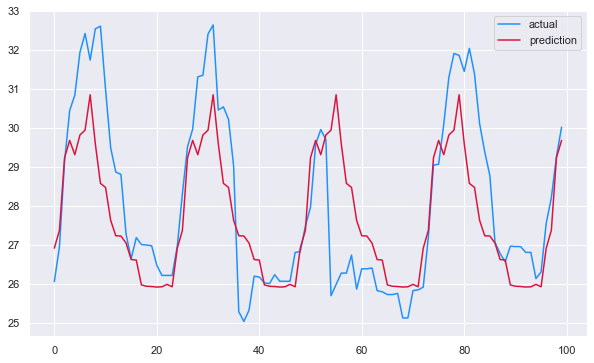

In [82]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module
scores = scoring.score_regression(
    y_test=fc_df[target_column_name],
    y_pred=fc_df["predicted"],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET),
)

print("[Test data scores]\n")
for key, value in scores.items():
    print("{}: {:.3f}".format(key, value))

# Plot outputs
%matplotlib inline
plt.figure(figsize=(10,6))
fc_df['temp'][:100].plot(label='actual', color='dodgerblue', linewidth=1.5)
fc_df['predicted'][:100].plot(label='prediction', color='crimson', linewidth=1.5)
plt.legend()

In [ ]:
description = "AutoML Weather Forecaster"
tags = None
model = remote_run.register_model(
    model_name=model_name, description=description, tags=tags
)

print(remote_run.model_id)